In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier 
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# ЗАВАНТАЖЕННЯ ДАНИХ
df = pd.read_csv('hackathon_int20h_dataset_test.csv')
# ПЕРЕТВОРЕННЯ ДАТИ
df['created_at'] = pd.to_datetime(df['created_at'])
df['processed_at'] = pd.to_datetime(df['processed_at'])



In [2]:
#Первинна діагностика
print("--- Розмірність датасету ---")
print(df.shape) 

print("\n--- Типи даних та пропуски ---")
print(df.info()) 

print("\n--- Перші 5 записів ---")
print(df.head())

--- Розмірність датасету ---
(1000000, 18)

--- Типи даних та пропуски ---
<class 'pandas.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 18 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   created_at          1000000 non-null  datetime64[us]
 1   order_id            1000000 non-null  int64         
 2   processed_at        1000000 non-null  datetime64[us]
 3   order_type          1000000 non-null  str           
 4   user_id             1000000 non-null  int64         
 5   ip_country          1000000 non-null  str           
 6   currency            1000000 non-null  str           
 7   amount              1000000 non-null  float64       
 8   payment_method      1000000 non-null  str           
 9   order_payment_type  599474 non-null   str           
 10  bin_country         1000000 non-null  str           
 11  bank_id             1000000 non-null  int64         
 12  psp_id 


Статистика статусів:
status
success    525114
fail       474886
Name: count, dtype: int64


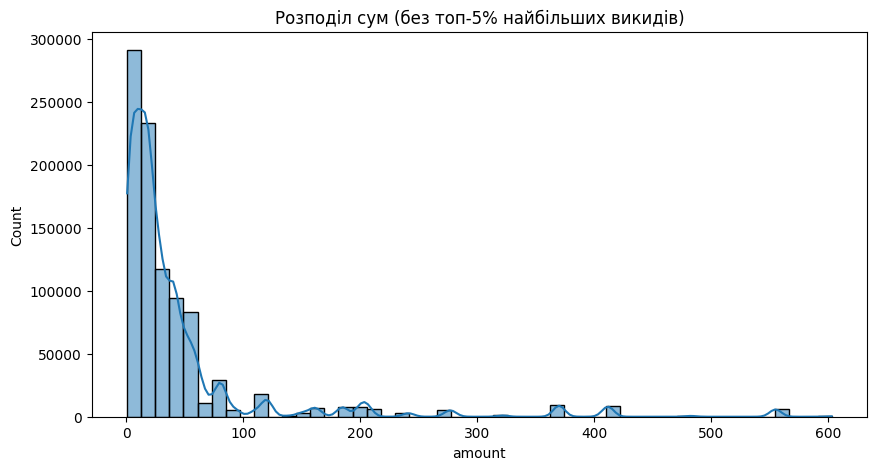


Топ-10 кодів помилок:
error_code
3.02    150121
3.08     90293
3.10     76797
2.12     44700
2.01     43696
3.04     42896
4.09     17647
4.03      1520
3.01      1468
0.01      1468
Name: count, dtype: int64


In [5]:
# 1. Перевірка дисбалансу класів
# Якщо у вас уже є колонка is_anomaly в навчальному наборі
#if 'is_anomaly' in df.columns:
    #print("Розподіл класів:")
    #print(df['is_anomaly'].value_counts(normalize=True)) 
    
    #plt.figure(figsize=(6, 4))
    #sns.countplot(x='is_anomaly', data=df)
    #plt.title('Кількість нормальних (0) та аномальних (1) транзакцій')
    #plt.show()

#У нас немає колонки is_anomaly тому цей абзац нам по суті не потрібен

# 2. Аналіз статусів та помилок
# Аномалії часто корелюють зі статусом 'fail' 
print("\nСтатистика статусів:")
print(df['status'].value_counts())

# 3. Розподіл сум транзакцій (amount)
# Шукаємо "викиди" (дуже великі суми) 
plt.figure(figsize=(10, 5))
sns.histplot(df[df['amount'] < df['amount'].quantile(0.95)]['amount'], bins=50, kde=True)
plt.title('Розподіл сум (без топ-5% найбільших викидів)')
plt.show()

# 4. Кореляція помилок та аномалій
# Дивимося, які error_code виникають найчастіше 
top_errors = df['error_code'].value_counts().head(10)
print("\nТоп-10 кодів помилок:")
print(top_errors)


In [8]:
# 1. Різниця в країнах (IP vs Bank)
df['country_mismatch'] = (df['ip_country'] != df['bin_country']).astype(int)

# 2. Час обробки в секундах
df['processing_duration'] = (df['processed_at'] - df['created_at']).dt.total_seconds()

# 3. Чи є сума повернення аномальною (наприклад, більше початкової суми)
df['excessive_refund'] = (df['refunded_amount'] > df['amount']).astype(int)

# 4. Нічні транзакції (наприклад, з 00:00 до 05:00)
df['hour'] = df['created_at'].dt.hour
df['is_night'] = df['hour'].apply(lambda x: 1 if x < 5 else 0)

In [10]:
from sklearn.ensemble import IsolationForest

# 1. Вибираємо ознаки, на основі яких модель шукатиме дивацтва
# Додаємо створені раніше ознаки (наприклад, різниця країн або час обробки)
features_for_model = [
    'amount', 
    'processing_duration', 
    'country_mismatch', 
    'is_night', 
    'is_secured'
]

# Створюємо чистий набір даних для моделі, заповнюючи пропуски (NaN) нулями
X = df[features_for_model].fillna(0)

# 2. Налаштування моделі
# contamination = 0.01 означає, що ми очікуємо приблизно 1% аномалій у системі
model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)

# 3. ТУТ МИ СТВОРЮЄМО СТОВПЕЦЬ is_anomaly
# fit_predict поверне -1 для аномалій та 1 для нормальних транзакцій
df['anomaly_score'] = model.fit_predict(X)

# Перетворюємо у формат згідно з ТЗ: 1 - аномалія, 0 - норма
df['is_anomaly'] = df['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)

print(f"Виявлено аномалій: {df['is_anomaly'].sum()} з {len(df)}")

Виявлено аномалій: 9967 з 1000000


--- Порівняння груп (0 - норма, 1 - аномалія) ---
                 amount  processing_duration  country_mismatch
is_anomaly                                                    
0             97.674843            31.672893          0.140338
1           1849.340256           401.844888          0.534062


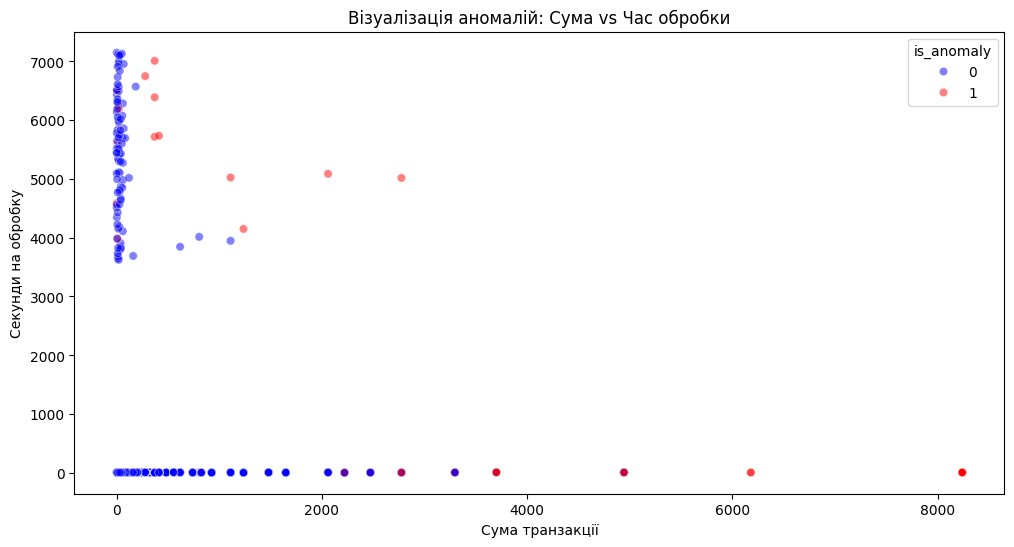


--- Топ кодів помилок серед аномальних транзакцій ---
error_code
3.08    1520
3.02    1328
2.12     811
3.10     674
2.01     394
Name: count, dtype: int64


In [ ]:
# 1. Порівнюємо середні показники
# Ми хочемо побачити, чи дійсно у аномалій сума або час обробки вищі
report = df.groupby('is_anomaly')[['amount', 'processing_duration', 'country_mismatch']].mean()
print("--- Порівняння груп (0 - норма, 1 - аномалія) ---")
print(report)

# 2. Візуалізація: Де саме знаходяться аномалії?
plt.figure(figsize=(12, 6))

# Беремо випадкову вибірку для швидкості візуалізації (наприклад, 20 000 транзакцій)
sample_df = df.sample(20000)

sns.scatterplot(
    data=sample_df, 
    x='amount', 
    y='processing_duration', 
    hue='is_anomaly', 
    palette={0: 'blue', 1: 'red'},
    alpha=0.5
)

plt.title("Візуалізація аномалій: Сума vs Час обробки")
plt.xlabel("Сума транзакції")
plt.ylabel("Секунди на обробку")
plt.show()

# 3. Аналіз кодів помилок для аномалій
print("\n--- Топ кодів помилок серед аномальних транзакцій ---")
print(df[df['is_anomaly'] == 1]['error_code'].value_counts().head(5))

In [12]:
submission = df[['order_id', 'is_anomaly']]
submission.to_csv('submission.csv', index=False)
print("Файл готовий до відправки!")

Файл готовий до відправки!


In [ ]:
#df1 = pd.read_csv('hackathon_int20h_dataset_test.csv')
#df2 = pd.read_csv('submission.csv')
#full_info = pd.concat([df1, df2], axis=1)
#full_info[full_info['is_anomaly']==1]
#це я просто дивилася які транзакції аномальні

,created_at,order_id,processed_at,order_type,user_id,ip_country,currency,amount,payment_method,order_payment_type,bin_country,bank_id,psp_id,has_refund,refunded_amount,is_secured,status,error_code,order_id,is_anomaly
102,2025-12-26 13:23:58,103,2025-12-26 13:24:02,recurring,147462,UKR,UAH,3296.0,card,recurring,MEX,18,psp_alpha,False,0.0,False,fail,3.08,103,1
273,2025-02-02 03:21:01,274,2025-02-02 03:21:04,recurring,560674,UKR,UAH,1648.0,card,retry,GBR,32,psp_gamma,False,0.0,False,fail,3.02,274,1
407,2025-10-20 01:18:45,408,2025-10-20 01:18:54,recurring,853823,MEX,MXN,925.0,googlepay,rebill,POL,31,psp_alpha,False,0.0,False,success,NaN,408,1
461,2025-09-19 03:00:23,462,2025-09-19 03:00:25,recurring,372732,UKR,UAH,4944.0,googlepay,retry,GBR,42,psp_beta,False,0.0,False,fail,3.04,462,1
474,2025-11-11 20:10:57,475,2025-11-11 20:11:03,recurring,667560,UKR,UAH,6180.0,applepay,recurring,CAN,41,psp_gamma,False,0.0,False,success,NaN,475,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998837,2025-04-18 21:34:55,998838,2025-04-18 21:35:01,recurring,177934,UKR,UAH,4944.0,googlepay,recurring,UKR,15,psp_beta,False,0.0,False,success,NaN,998838,1
998856,2025-05-14 13:48:57,998857,2025-05-14 15:06:15,recurring,183537,UKR,UAH,2472.0,card,1-click,UKR,8,psp_gamma,False,0.0,False,success,NaN,998857,1
998900,2025-04-07 02:46:09,998901,2025-04-07 02:46:19,recurring,841127,UKR,UAH,3296.0,card,rebill,UKR,14,psp_beta,False,0.0,False,success,NaN,998901,1
999305,2025-11-23 00:06:25,999306,2025-11-23 00:06:30,first,145908,MEX,MXN,92.5,card,NaN,DEU,20,psp_beta,False,0.0,True,fail,2.12,999306,1
